In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 
import numpy as np
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import ADF as ARCH_ADF # type: ignore
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [147]:
data = pd.read_csv(r"C:\Users\yazid\Downloads\INVEST.csv", parse_dates=['observation_date'])
data.columns = ['DATE', 'INVEST']
data = data.set_index('DATE').asfreq('MS')  # monthly start freq
print(data.head())
print(data.tail())
data.columns

             INVEST
DATE               
1947-01-01  82.3793
1947-02-01  81.2734
1947-03-01  80.5653
1947-04-01  80.1894
1947-05-01  79.6067
               INVEST
DATE                 
2025-06-01  5555.2012
2025-07-01  5585.9770
2025-08-01  5624.5521
2025-09-01  5643.7486
2025-10-01  5655.4704


Index(['INVEST'], dtype='object')

ABOUT THE DATA: it measures the dollar value of investment securities held by U.S. commercial banks over time.
#1️ Macroeconomic Financial Series → Usually follows a Stochastic Trend
#2️ Data is Seasonally Adjusted → seasonal pattern has already been removed

In [148]:
data.head(10)

,INVEST
DATE,
1947-01-01,82.3793
1947-02-01,81.2734
1947-03-01,80.5653
1947-04-01,80.1894
1947-05-01,79.6067
1947-06-01,78.8543
1947-07-01,77.7495
1947-08-01,77.5449
1947-09-01,77.9527


In [149]:
data.columns

Index(['INVEST'], dtype='object')

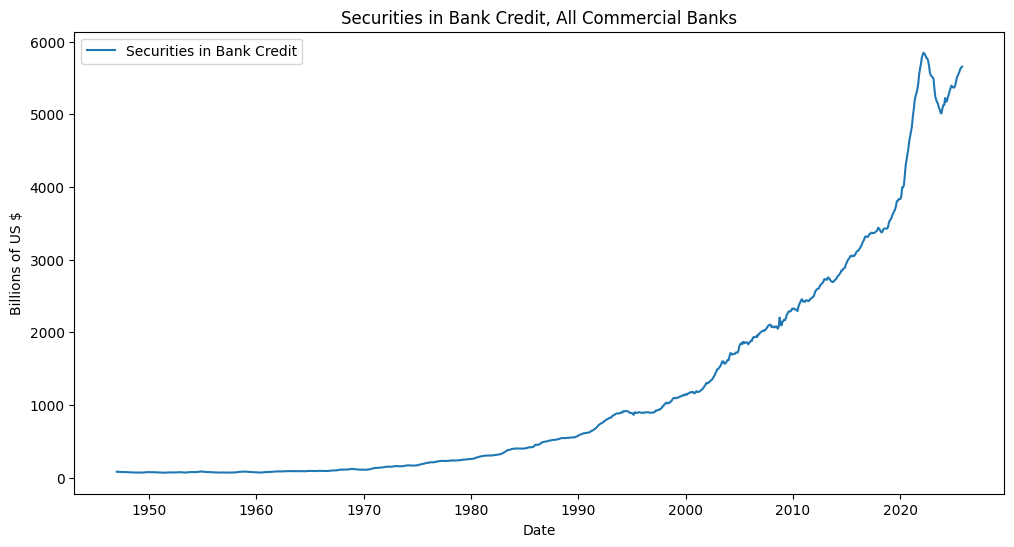

In [150]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['INVEST'], label='Securities in Bank Credit')
plt.title('Securities in Bank Credit, All Commercial Banks')
plt.xlabel('Date')
plt.ylabel('Billions of US $')
plt.legend()
plt.show()

The Overall pattern of the data shows a trend (visually speaking) but we still want to know the type of it. So we will plot the mean against the time to see whether it is a deterministic trend or a stochastic trend. 

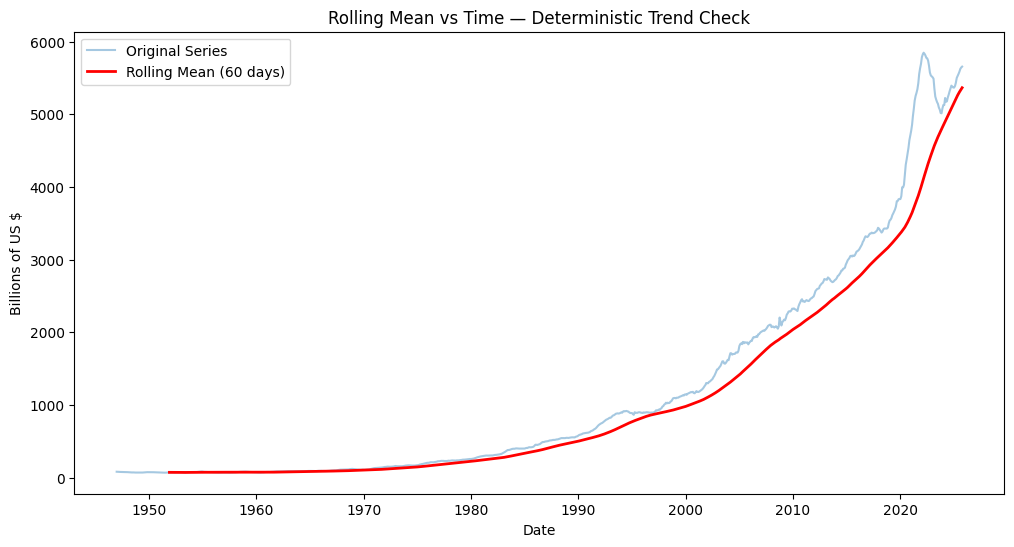

In [151]:
plt.figure(figsize=(12,6))

# original series
plt.plot(data['INVEST'], alpha=0.4, label='Original Series')

# rolling mean (choose window depending on frequency — here ~60 days)
rolling_mean = data['INVEST'].rolling(window=60).mean()
plt.plot(rolling_mean, color='red', linewidth=2, label='Rolling Mean (60 days)')

plt.title("Rolling Mean vs Time — Deterministic Trend Check")
plt.xlabel("Date")
plt.ylabel("Billions of US $")
plt.legend()
plt.show()

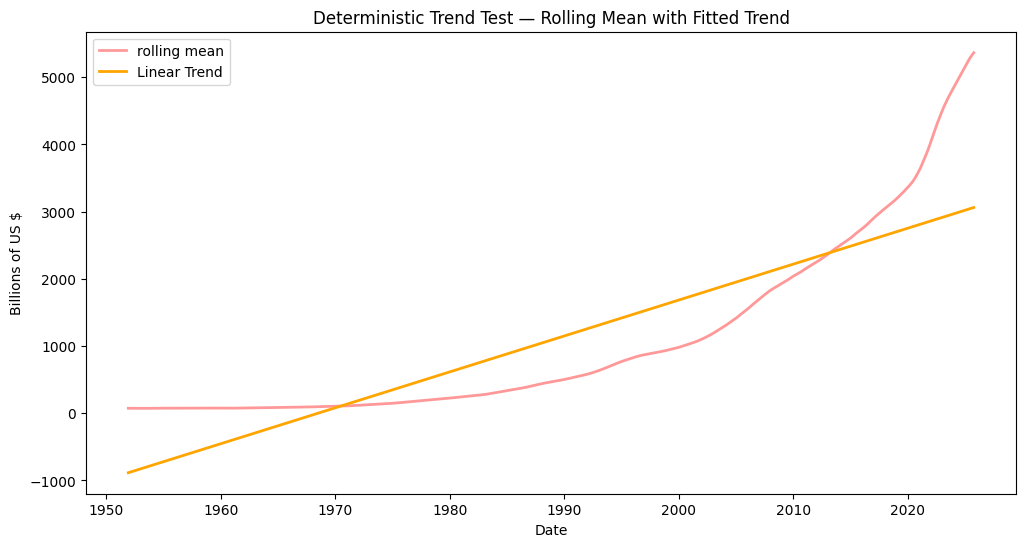

Trend slope: 4.454622958500683


In [152]:
from sklearn.linear_model import LinearRegression
rolling_mean=rolling_mean.dropna()
X = np.arange(len(rolling_mean)).reshape(-1, 1)
y = rolling_mean.values

model = LinearRegression().fit(X, y)
trend = model.predict(X)

plt.figure(figsize=(12,6))
plt.plot(rolling_mean.index, rolling_mean, alpha=0.4, label='rolling mean', color='red', linewidth=2)
plt.plot(rolling_mean.index, trend, color='orange', linewidth=2, label='Linear Trend')
plt.title("Deterministic Trend Test — Rolling Mean with Fitted Trend")
plt.xlabel("Date")
plt.ylabel("Billions of US $")
plt.legend()
plt.show()
print("Trend slope:", model.coef_[0])

The fitted line do not capture the variance of the mean perfectly and to comfirm that we can look at the r square of the model=>

In [153]:
from sklearn.metrics import r2_score

r2 = r2_score(y, trend) #recall: y is the rolling mean
print("R²:", r2)

R²: 0.7532673705976549


Interpretation of R² = 0.753

About 75.3% of the variance in the rolling mean is explained by a simple linear trend.

That is not random, so there is a meaningful long-run upward pattern.

But 24.7% remains unexplained, meaning shocks, cycles, policy changes, crises, etc. still drive behavior.

So the trend is partly deterministic, but not fully.

Let's test for non determintic trend!

In [155]:

X2 = np.column_stack([X, X**2])
model2 = LinearRegression().fit(X2, y) # recall: y is the rolling mean
print("Quadratic R²:", model2.score(X2, y))

Quadratic R²: 0.9698037711105898


R² jumps → curved deterministic trend exists.

The question to ask now is what type of deterministic trend we have? Linear? exponential? 
Given that the overal data looks like it has an exponential deterministic trend we'll try to visualize its Log to see if the log of raw data is linear than we have an exponential trend!

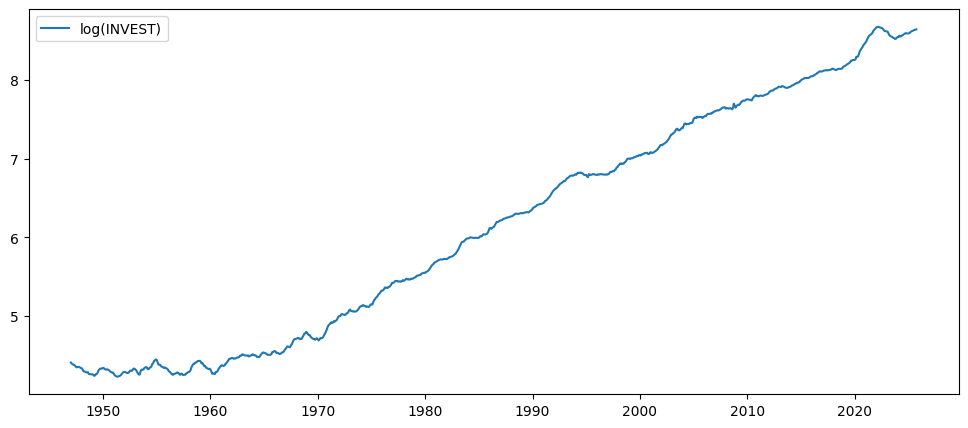

In [156]:
# log transform (if positive) and monthly pct change
data['log_INVEST'] = np.log(data['INVEST'])
plt.figure(figsize=(12,5))
plt.plot(data['log_INVEST'], label='log(INVEST)')
plt.legend(); plt.show()

The log of the original data gives a linear trend==> we can conclude that the data follows a deterministic trend that is "exponensial" / so an imporatnt phase of the detrending should be the log transformation of the data.

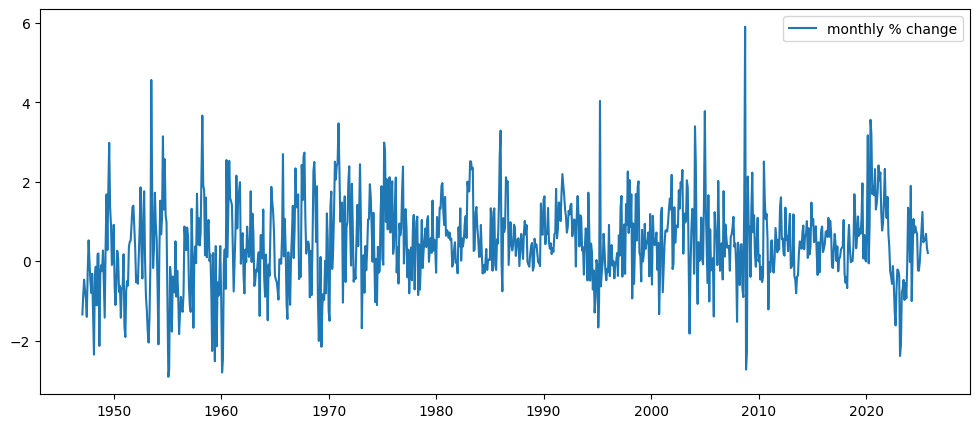

In [157]:
data['pct_change'] = data['INVEST'].pct_change() * 100  # percentage
plt.figure(figsize=(12,5))
plt.plot(data['pct_change'], label='monthly % change')
plt.legend(); plt.show()

Having a trend already is a sign that there is no stationarity. but let's double check using two tests:ADF: Augmented Dickey–Fuller Test and KPSS: Kwiatkowski–Phillips–Schmidt–Shin Test

In [158]:
# 3. Stationarity tests (ADF and KPSS)
def adf_test(series, title='Series'):
    print(f'--- ADF Test: {title} ---')
    res = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF stat {res[0]:.4f}, p-value {res[1]:.4f}')
    print('Used lags:', res[2], 'nobs:', res[3])
    for k,v in [('1%','0.01'),('5%','0.05'),('10%','0.10')]:
        pass
    print('crit values:', res[4])
    print()
#ADF=> H0=Series is not stationary /If p-value < 0.05 → reject H₀ → likely stationary

 # The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test is a statistical test for stationarity in a time series, but it works opposite to the ADF test.
def kpss_test(series, regression='c', title='Series'):
    print(f'--- KPSS Test ({regression}): {title} ---')
    res = kpss(series.dropna(), regression=regression, nlags='auto')
    print(f'KPSS stat {res[0]:.4f}, p-value {res[1]:.4f}')
    print('Used lags:', res[2])
    print('crit values:', res[3])
    print()
#KPSS=> H0=Series is stationary /	If p-value < 0.05 → reject H₀ → likely non-stationary


In [159]:
adf_test(data['INVEST'], 'INVEST (level)')
kpss_test(data['INVEST'], regression='c', title='INVEST (level)')
# Here we are testing stationarity for "raw data", we find:
# ADF : p value 1.000 > 0.05 => do not reject H0 => original data is not stationary
# KPSS ; p value 0.01 <0.05 => reject H0 => original data is is not stationary

--- ADF Test: INVEST (level) ---
ADF stat 3.8242, p-value 1.0000
Used lags: 17 nobs: 928
crit values: {'1%': np.float64(-3.4374162506455126), '5%': np.float64(-2.8646595140022946), '10%': np.float64(-2.568431020409111)}

--- KPSS Test (c): INVEST (level) ---
KPSS stat 3.6937, p-value 0.0100
Used lags: 19
crit values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



C:\Users\yazid\AppData\Local\Temp\ipykernel_5880\409635658.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


In [160]:
adf_test(data['log_INVEST'], 'log(INVEST)')
kpss_test(data['log_INVEST'], regression='c', title='log(INVEST)')
# here we are testing the stationarity of the log transformed data:
# ADF : p value 0.99 > 0.05 => not stationary
# KPSS: p value 0.01<0.05 => not stationary
# even after log transformation data is still not stationary => that is why we'll move to the differencing (for detrending)

--- ADF Test: log(INVEST) ---
ADF stat 1.3700, p-value 0.9970
Used lags: 22 nobs: 923
crit values: {'1%': np.float64(-3.437454636606558), '5%': np.float64(-2.8646764401027336), '10%': np.float64(-2.5684400361180333)}

--- KPSS Test (c): log(INVEST) ---
KPSS stat 4.8297, p-value 0.0100
Used lags: 19
crit values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



C:\Users\yazid\AppData\Local\Temp\ipykernel_5880\409635658.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna(), regression=regression, nlags='auto')


In [161]:
adf_test(data['pct_change'], 'INVEST pct change')
kpss_test(data['pct_change'], regression='c', title='INVEST pct change')
# here we are testing the stationarity of the % of change of the original data:
# ADF : p value 0.0.00 < 0.05 =>  stationary
# KPSS: p value 0.0229  <0.05 => not stationary => KPSS seems to be more accurate!

--- ADF Test: INVEST pct change ---
ADF stat -6.6830, p-value 0.0000
Used lags: 22 nobs: 922
crit values: {'1%': np.float64(-3.437462363899248), '5%': np.float64(-2.8646798473884134), '10%': np.float64(-2.568441851017076)}

--- KPSS Test (c): INVEST pct change ---
KPSS stat 0.5967, p-value 0.0229
Used lags: 15
crit values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



In [162]:
#After comfirming that the time series we have is not stationary we move to the detrending by differencing
data["log_INVEST"] = np.log(data["INVEST"])
data["d_log_INVEST"] = data["log_INVEST"].diff()
data = data.dropna()

<Figure size 1200x400 with 0 Axes>

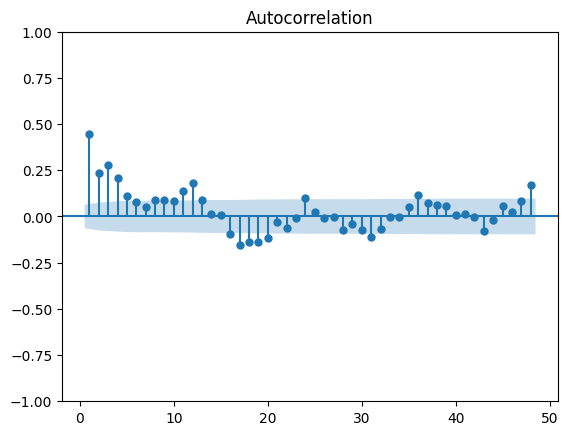

<Figure size 1200x400 with 0 Axes>

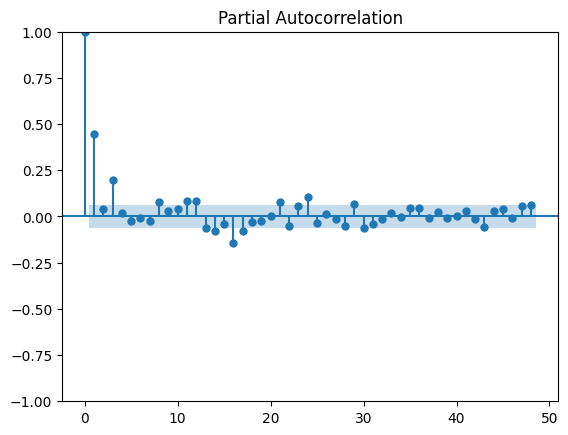

In [163]:
plt.figure(figsize=(12,4))
plot_acf(data["d_log_INVEST"], lags=48, zero=False) # => to identify the orders of the model p and q of the ARIMA
plt.show()
# after lag 1 the acf becomes on average zero
plt.figure(figsize=(12,4))
plot_pacf(data["d_log_INVEST"], lags=48, method="ywm")
plt.show()
# after lag 1 the pacf becomes on average zero
# so we can tell that after one differencing the p and q might be both 1

In [172]:
# 6. Using auto_arima to get candidate models
auto = pm.auto_arima(
    data['log_INVEST'].dropna(),
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,             # let auto determine d
    seasonal=False,  # data was originally not seasonal (mentioned in the data website)
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    D=None,             
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-5843.494, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-5934.345, Time=0.61 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-6074.779, Time=0.58 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-5845.493, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-6147.757, Time=1.68 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-6089.743, Time=1.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-6112.134, Time=0.45 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-6135.201, Time=1.97 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-6064.183, Time=0.43 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-6103.094, Time=0.81 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-6149.563, Time=1.83 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-6076.764, Time=0.45 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-5936.344, Time=0.41 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-6091.735, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0

BEST MODEL IS THE ONE WITH THE LOWER: AIC: ARIMA(1,2,1)(0,0,0)[0] 

In [173]:
# 7. Fit a SARIMAX model using statsmodels 
order = auto.order
seasonal_order = auto.seasonal_order
print("Fitting SARIMAX", order, seasonal_order)

model = SARIMAX(data['log_INVEST'].dropna(), order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(maxiter=200)
print(res.summary())

Fitting SARIMAX (1, 2, 1) (0, 0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:             log_INVEST   No. Observations:                  945
Model:               SARIMAX(1, 2, 1)   Log Likelihood                3070.561
Date:                Sun, 23 Nov 2025   AIC                          -6135.121
Time:                        23:47:04   BIC                          -6120.580
Sample:                    02-01-1947   HQIC                         -6129.578
                         - 10-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4206      0.021     19.749      0.000       0.379       0.462
ma.L1         -0.9883      0.006   -164.334      0.000      -1.000      -0.976
sigma2      8

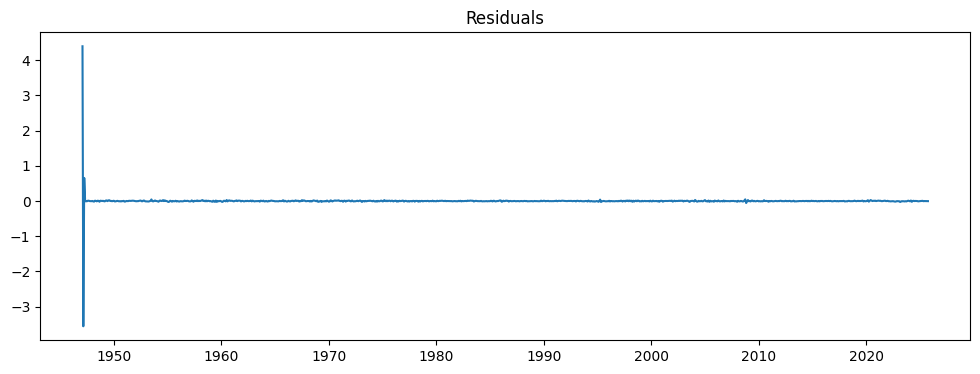

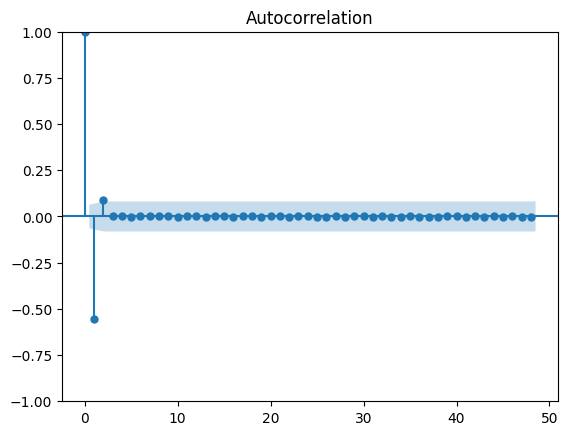

       lb_stat     lb_pvalue
12  297.545867  1.537862e-56
24  297.587831  5.128757e-49
36  297.622791  6.427535e-43
Jarque-Bera stat, p-value: SignificanceResult(statistic=np.float64(8881091.00971726), pvalue=np.float64(0.0))
ARCH test: (np.float64(76.71483637149242), np.float64(2.2040298019212862e-12), 8.258852862792816, 6.453589059961068e-13)


In [174]:
# 8. Diagnostics
# residuals
resid = res.resid
plt.figure(figsize=(12,4))
plt.plot(resid); plt.title('Residuals'); plt.show()

# Residual ACF
plot_acf(resid.dropna(), lags=48); plt.show()

# Ljung-Box for residuals
lb = acorr_ljungbox(resid.dropna(), lags=[12,24,36], return_df=True)
print(lb)

# Normality test
from scipy.stats import jarque_bera
jb = jarque_bera(resid.dropna())
print('Jarque-Bera stat, p-value:', jb)

# ARCH test for heteroscedasticity
from arch.unitroot import ADF as ARCH_ADF  # type: ignore # (optional)
# simpler: use statsmodels' het_arch
from statsmodels.stats.diagnostic import het_arch
print('ARCH test:', het_arch(resid.dropna()))

In [175]:
# 9. Forecasting & evaluation (train/test)
# Split last 36 months as test 
train = data['log_INVEST'][:'2022-12-01'] 
test = data['log_INVEST']['2023-01-01':]   

model_train = SARIMAX(train.dropna(), order=order)
res_train = model_train.fit(disp=False)

n_steps = len(test)
pred = res_train.get_forecast(steps=n_steps)
pred_mean_log = pred.predicted_mean
pred_ci = pred.conf_int()

# convert back from log to level
pred_mean = np.exp(pred_mean_log)
test_level = np.exp(test)


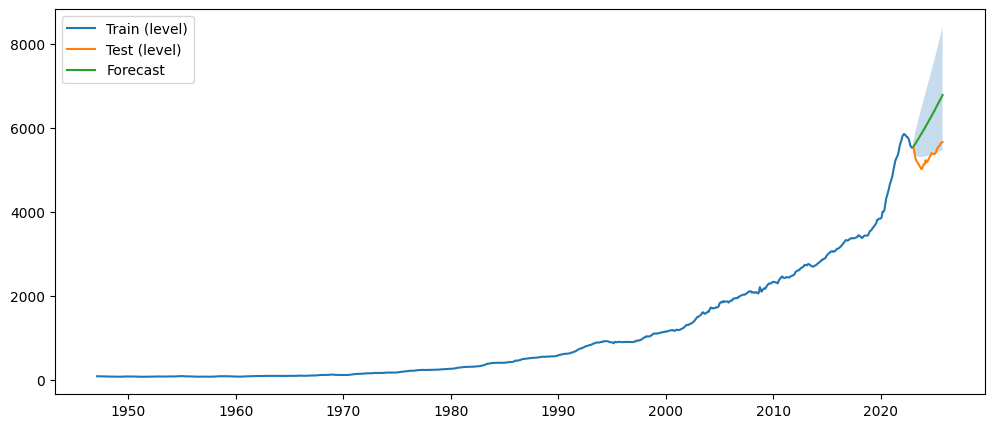

In [176]:
# plot
plt.figure(figsize=(12,5))
plt.plot(np.exp(train), label='Train (level)')
plt.plot(test_level, label='Test (level)')
plt.plot(pred_mean, label='Forecast')
plt.fill_between(pred_ci.index,
                 np.exp(pred_ci.iloc[:,0]),
                 np.exp(pred_ci.iloc[:,1]), alpha=0.25)
plt.legend(); plt.show()


In [177]:
# metrics
# --- Accuracy metrics ---
mae = mean_absolute_error(test_level, pred_mean)
rmse = math.sqrt(mean_squared_error(test_level, pred_mean))
mape = np.mean(np.abs((test_level - pred_mean) / test_level)) * 100

# Convert MAPE to "accuracy" %
accuracy = 100 - mape
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAE: 810.7552
RMSE: 858.0919
MAPE: 15.22%
Approximate Accuracy: 84.78%


Let's Forecast or Predict a specific date

In [183]:
# Specify the exact date to predict
future_date = '2030-01-01'  # replace with your target date

# Forecast that single date
#  res is the fitted SARIMAX model
pred = res.get_prediction(start=future_date, end=future_date)
pred_mean_log = pred.predicted_mean.iloc[0]
pred_ci = pred.conf_int().iloc[0]

# Convert back from log to level
pred_mean = np.exp(pred_mean_log)
pred_lower = np.exp(pred_ci[0])
pred_upper = np.exp(pred_ci[1])

print(f"Forecast for {future_date}: {pred_mean:.2f} Billion US $")
print(f"95% CI: [{pred_lower:.2f}, {pred_upper:.2f}]")

Forecast for 2030-01-01: 7116.50 Billion US $
95% CI: [5335.47, 9492.04]


C:\Users\yazid\AppData\Local\Temp\ipykernel_5880\496712515.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_lower = np.exp(pred_ci[0])
C:\Users\yazid\AppData\Local\Temp\ipykernel_5880\496712515.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_upper = np.exp(pred_ci[1])
